# MINI PROJECT

## Stock Prediction Price Prediction using machine learning

In [1]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

from matplotlib import style
from datetime import datetime as dt

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split    #Instead of cross_validation

style.use('ggplot')

1. Reading the dataset
2. Filtering w/ CSCO 
3. Printing the last 5 rows of Data

In [2]:
df=pd.read_csv('prices.csv',parse_dates=['date'], index_col='date')

#df=df.loc[df['symbol'] == 'CSCO']
df=df.loc[df['symbol'] == 'ANTM']

print(df.tail())

           symbol        open       close         low        high     volume
date                                                                        
2016-12-23   ANTM  144.830002  146.020004  144.000000  146.039993   428700.0
2016-12-27   ANTM  146.020004  145.679993  145.410004  147.139999   361100.0
2016-12-28   ANTM  145.750000  144.259995  144.009995  146.600006   939800.0
2016-12-29   ANTM  144.750000  144.759995  144.330002  145.949997   568000.0
2016-12-30   ANTM  144.880005  143.770004  143.110001  145.500000  1085700.0


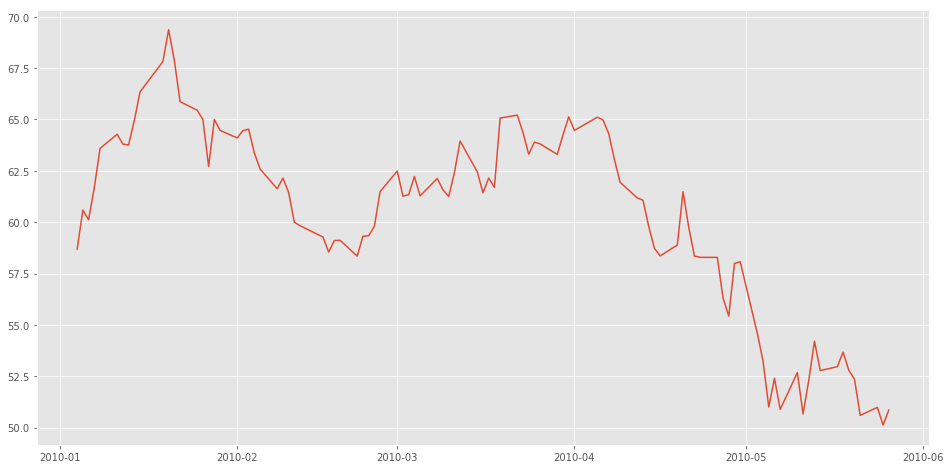

In [3]:
ts_open = df['open']
ts_open = ts_open.head(100)
plt.figure(figsize=(16,8))
plt.plot(ts_open, label='Open Price History')

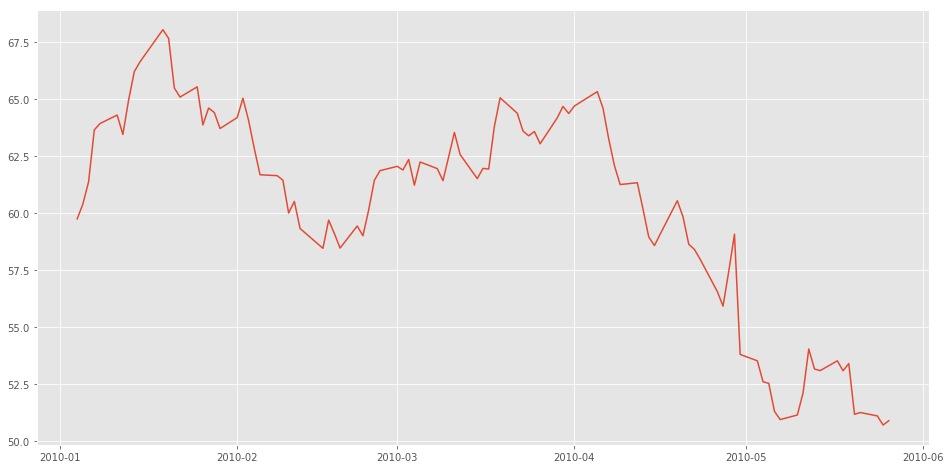

In [4]:
ts_close = df['close']
ts_close = ts_close.head(100)
plt.figure(figsize=(16,8))
plt.plot(ts_close, label='Close Price history')

## FEATURE ENGINEERING
Removing Not a number/Null Values and replacing them with a dummy value

In [5]:
#Consider daily volatility, such as with the high minus low % change
df['HL_PCT'] = (df['high'] - df['low']) / df['low'] * 100.0

#Consider percent change volatility i.e. daily percent change
df['PCT_change'] = (df['close'] - df['open']) / df['open'] * 100.0

df = df[['close', 'HL_PCT', 'PCT_change', 'volume']]

print(df.tail())

                 close    HL_PCT  PCT_change     volume
date                                                   
2016-12-23  146.020004  1.416662    0.821654   428700.0
2016-12-27  145.679993  1.189736   -0.232852   361100.0
2016-12-28  144.259995  1.798494   -1.022302   939800.0
2016-12-29  144.759995  1.122424    0.006905   568000.0
2016-12-30  143.770004  1.670043   -0.766152  1085700.0


In [6]:
forecast_col = 'close'
df.fillna(value=-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head())

                close    HL_PCT  PCT_change     volume      label
date                                                             
2010-01-04  59.750000  2.449469    1.806102  4641800.0  63.720001
2010-01-05  60.400002  1.794918   -0.313580  8385500.0  64.199997
2010-01-06  61.380001  2.345309    2.095812  6449100.0  65.050003
2010-01-07  63.660000  4.164624    3.210117  6028900.0  64.070000
2010-01-08  63.939999  1.682276    0.550399  5270900.0  62.830002


Dropping the columns Label, Symbol and Date

In [7]:
X=np.array(df.drop(['label'], axis=1))

Performing Standardization i.e. Mean Removal and Variance Scaling.

Data Standardization:
Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).
It is useful to standardize attributes for a model that relies on the distribution of attributes such as Gaussian processes.

In [8]:
X = preprocessing.scale(X)

In [9]:
X_lately = X[-forecast_out:]

Split arrays or matrices into random train and test subsets.

test_size : float, int or None, optional (default=0.25).
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split

In [10]:
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# SUPPORT VECTOR REGRESSOR
### TRAINING & TESTING THE MODEL

In [11]:
clf = svm.SVR()

clf = clf.fit(X_train,y_train)

confidence = clf.score(X_test,y_test)
print(confidence)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9273041225914841


## Predicting

[138.90937774 140.28519679 138.21840424 141.3709341  144.04515035
 142.33479106 137.90849652 137.99965001 141.85762039 141.10950719
 138.60473455 137.00075647 137.32803915 134.85590189 135.17430108
 138.32680732 135.99772409 140.12060838]
2016-12-05 00:00:00
                     close  HL_PCT  PCT_change  volume  label    Forecast
date                                                                     
2016-12-19 05:30:00    NaN     NaN         NaN     NaN    NaN  134.855902
2016-12-20 05:30:00    NaN     NaN         NaN     NaN    NaN  135.174301
2016-12-21 05:30:00    NaN     NaN         NaN     NaN    NaN  138.326807
2016-12-22 05:30:00    NaN     NaN         NaN     NaN    NaN  135.997724
2016-12-23 05:30:00    NaN     NaN         NaN     NaN    NaN  140.120608


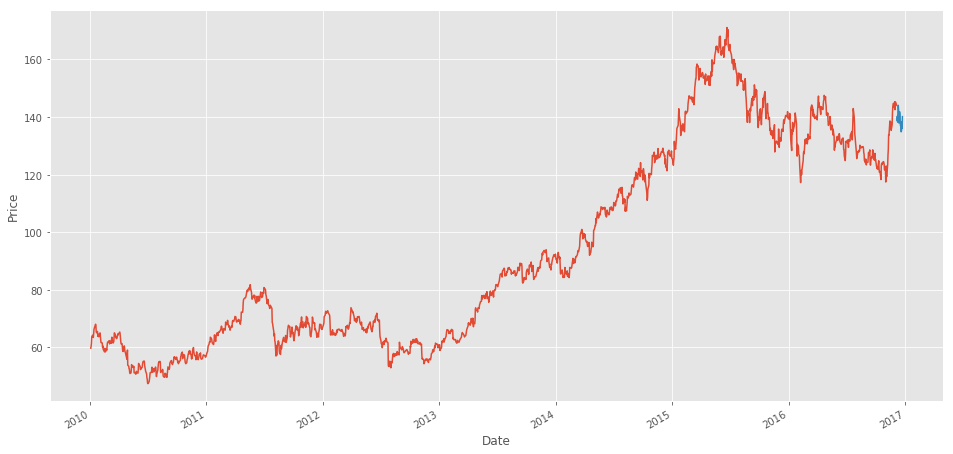

In [12]:
forecast_set = clf.predict(X_lately)
print(forecast_set)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
print(last_date)

last_unix = last_date.timestamp()

one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = dt.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
print(df.tail())

plt.figure(figsize=(16,8))
df['close'].plot()
df['Forecast'].plot()

#plt.legend(loc=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.show()